## Taller: Adquisición, procesamiento y visualización de datos

In [21]:
# librerías utilizadas
import pandas as pd
import unicodedata
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Funciones
def normalizar_texto(texto):
    texto=str(texto)
    if isinstance(texto, str):
        texto_normalizado = unicodedata.normalize('NFKD', texto)
        texto_sin_diacriticos = ''.join(c for c in texto_normalizado if not unicodedata.combining(c))
        return texto_sin_diacriticos
    return texto 
def eliminar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    filtro = (df[columna] >= Q1 - 1.5 * IQR) & (df[columna] <= Q3 + 1.5 * IQR)
    return df[filtro]

Parte 1: Adquisición y limpieza de datos

In [23]:
# lectura del archivo
df=pd.read_excel('Online Retail.xlsx')
# Dimensiones
print('filas:', len(df))
print('columnas:', len(df.columns))
# Tipos de variables
print('Nombre de la Variable\t','Datos Faltantes\t','Tipo',)
for col in df.columns:
    print(col,'\t\t',sum(df[col].isna()),'\t\t\t',type(df[col][0]))
# Imputacion de datos faltantes 
df.fillna({'CustomerID':99999,'Description':'NO DESCRIPTION'},inplace=True) 
# Cambio de tipo de dato 
df['CustomerID']=df['CustomerID'].astype(int)
df['InvoiceNo']=df['InvoiceNo'].astype(str)
# Corrección de typos
df['Country']=df['Country'].replace({'EIRE':'Ireland','RSA':'South Africa'})
# Normalizacion columna de texto
df['Description']=df['Description'].replace({'?': 'NO DESCRIPTION', '??': 'NO DESCRIPTION','???':'NO DESCRIPTION'})
df['Description']=df['Description'].apply(lambda x: x if 'missing' not in str(x) else 'NO DESCRIPTION')
df['Description'] = df['Description'].apply(normalizar_texto)
df['Description']=df['Description'].str.upper().str.replace('?','').str.strip()
stockcodes_con_error = df[df['Description'] == 'NO DESCRIPTION']['StockCode'].unique()
df_validas = df[(df['Description'] != 'NO DESCRIPTION') & (df['StockCode'].isin(stockcodes_con_error))]
descripcion_mas_frecuente = (df_validas.groupby('StockCode')['Description'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else '')    .to_dict())
df['Description']=df.apply(lambda row: descripcion_mas_frecuente[row['StockCode']] if row['Description']=='NO DESCRIPTION' and row['StockCode'] in descripcion_mas_frecuente  else row['Description'] ,axis=1)
# Carga a la base de datos
conn = sqlite3.connect('dataset.db')
df.to_sql('dataset', conn, if_exists='replace', index=False)
conn.close()

filas: 541909
columnas: 8
Nombre de la Variable	 Datos Faltantes	 Tipo
InvoiceNo 		 0 			 <class 'int'>
StockCode 		 0 			 <class 'str'>
Description 		 1454 			 <class 'str'>
Quantity 		 0 			 <class 'numpy.int64'>
InvoiceDate 		 0 			 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
UnitPrice 		 0 			 <class 'numpy.float64'>
CustomerID 		 135080 			 <class 'numpy.float64'>
Country 		 0 			 <class 'str'>


Parte 2: EDA

In [24]:
# Lectura de la base de datos
conn = sqlite3.connect('dataset.db') 
df = pd.read_sql_query("SELECT * FROM dataset", conn)
conn.close()
# Guardar una descripción
with open('description.txt', 'w', encoding='utf-8') as f:
    f.write('El conjunto de datos contiene 541909 registros de transacciones realizadas por una tienda en línea británica; entre las fechas 01/12/2010 y 09/12/2011.\nPara cada transacción se tienen 8 campos de información:\n\n')
    f.write('- *InvoiceNo*: Identificador único para cada factura (cadena alfanumérica)\n')
    f.write('- *StockCode*: Identificador unico para cada producto (cadena alfanumérica)\n')
    f.write('- *Description*: Nombre del producto (texto)\n')
    f.write('- *Quantity*: Unidades del producto por transacción (entero)\n')
    f.write('- *InvoiceDate*: Fecha y hora de la transacción (fecha y hora)\n')
    f.write('- *UnitPrice*: Precio unitario del producto (decimal)\n')
    f.write('- *CustomerID*: Identificador unico para cada cliente (entero)\n')
    f.write('- *Country*: País de residencia del cliente (texto)\n\n')
    f.write('A partir de este conjunto de datos se puede generar las siguientes preguntas:\n\n')
    f.write('* Que productos son los más comprados?\n')
    f.write('* Existen productos que son comprados juntos?\n')
    f.write('* Qué clientes son los más valiosos?\n')
    f.write('* Cuales son las características de los clientes valiosos?\n')
    f.write('* Existen patrones en el comportamiento de los clientes, de las ventas, o de los países a lo largo del tiempo?')

Parte 3: Visualización

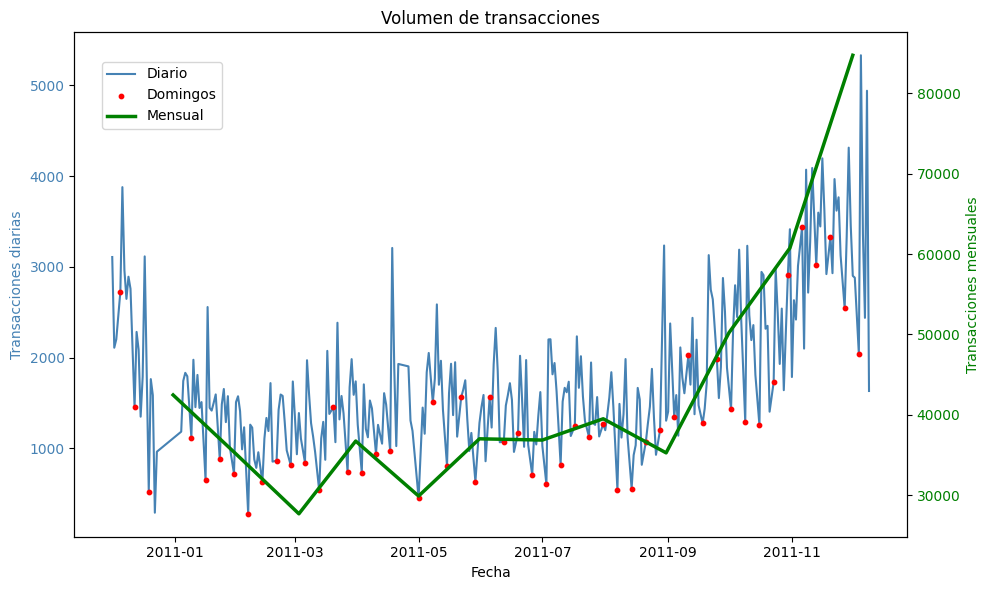

In [25]:
# Serie de tiempo de transacciones por día y mes
transacciones_por_dia = df.groupby(pd.to_datetime(df['InvoiceDate']).dt.date).size()
serie_diaria = transacciones_por_dia.reset_index()
serie_diaria.columns = ['Fecha', 'Transacciones_diarias']
serie_diaria['Fecha'] = pd.to_datetime(serie_diaria['Fecha'])
sábados = serie_diaria[serie_diaria['Fecha'].dt.weekday == 6]  
transacciones_por_mes = df.groupby(pd.to_datetime(df['InvoiceDate']).dt.to_period('M')).size()
serie_mensual = transacciones_por_mes.reset_index()
serie_mensual['Fecha'] = serie_mensual['InvoiceDate'].dt.to_timestamp() + pd.Timedelta(days=30)
serie_mensual.columns = ['Periodo', 'Transacciones_mensuales', 'Fecha']
serie_mensual = serie_mensual[serie_mensual['Periodo'] != '2011-12']

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
ax1.set_xlabel('Fecha')
ax1.plot(serie_diaria['Fecha'], serie_diaria['Transacciones_diarias'], color='steelblue', label='Diario')
ax2.plot(serie_mensual['Fecha'], serie_mensual['Transacciones_mensuales'], color='green', linewidth=2.5, label='Mensual')
ax1.scatter(sábados['Fecha'], sábados['Transacciones_diarias'], color='red', s=10, label='Domingos', zorder=5)
ax2.set_ylabel('Transacciones mensuales', color='green')
ax1.set_ylabel('Transacciones diarias', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax2.tick_params(axis='y', labelcolor='green')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.title('Volumen de transacciones')
fig.tight_layout()
plt.savefig("Imagenes/serie_tiempo_transacciones.png", dpi=300, bbox_inches='tight')
plt.show()


**Interpretación:** La empresa experimenta fluctuaciones significativas en su actividad diaria, con una crecida significativa en el último trimestre lo que sugiere una estacionariedad de los datos. Cabe resaltar que los valores minimos semanales se registran los domingos y no se registra información de los sábados.


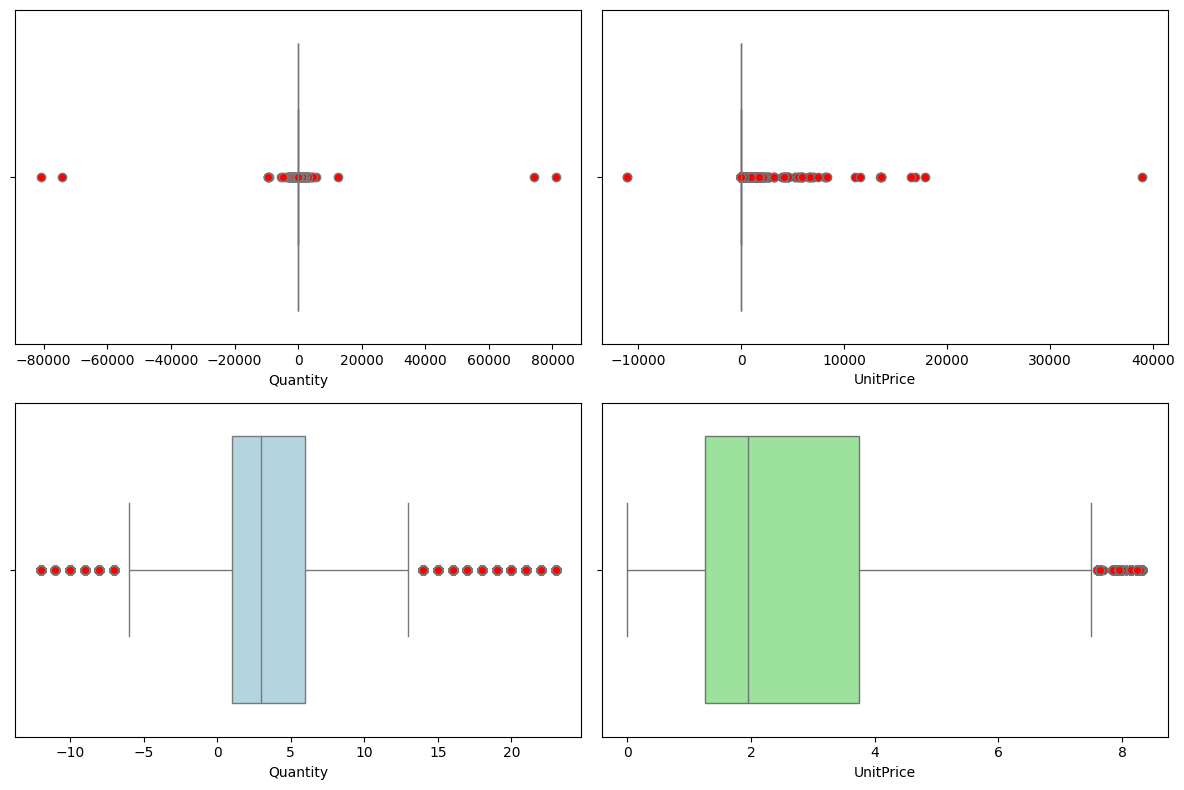

In [26]:
#Interacciones Cantidad y Precio Unitario
df_quantity = eliminar_outliers(df, 'Quantity')
df_unitprice = eliminar_outliers(df, 'UnitPrice') 

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.boxplot(x=df['Quantity'], color='lightblue',flierprops=dict(markerfacecolor='red', marker='o'))
plt.subplot(2, 2, 2)
sns.boxplot(x=df['UnitPrice'], color='lightgreen',flierprops=dict(markerfacecolor='red', marker='o'))
plt.subplot(2, 2, 3)
sns.boxplot(x=df_quantity['Quantity'], color='lightblue',flierprops=dict(markerfacecolor='red', marker='o'))
plt.subplot(2, 2, 4)
sns.boxplot(x=df_unitprice['UnitPrice'], color='lightgreen',flierprops=dict(markerfacecolor='red', marker='o'))
plt.tight_layout()
plt.savefig("Imagenes/boxplots_cantidad_precio.png", dpi=300, bbox_inches='tight')
plt.show()

**Interpretación:** La mayoría de las transacciones se concentran en rangos bajos de cantidad y precio, pero existen excepciones que podrían requerir revisión o un análisis específico.

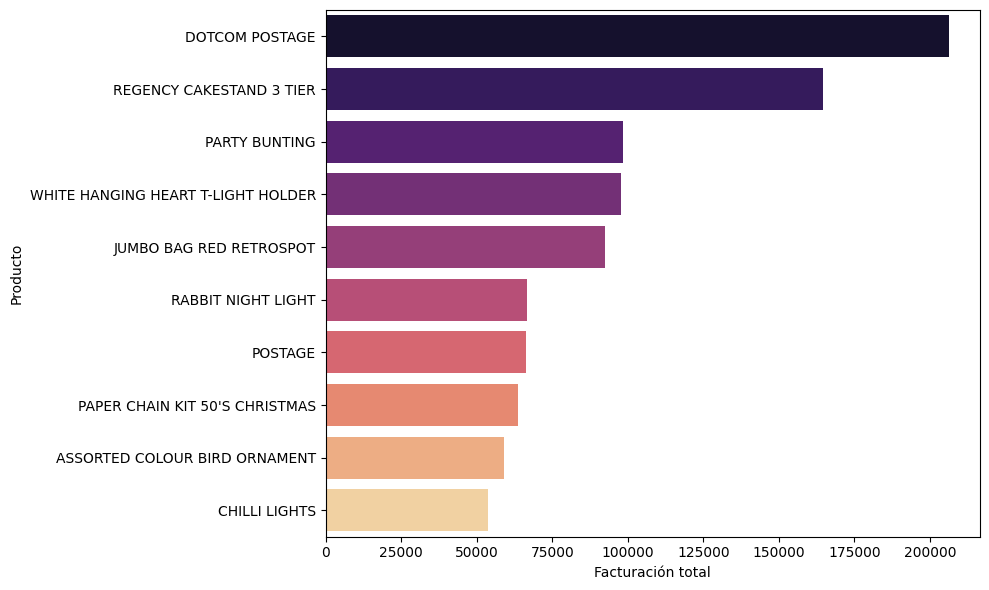

In [27]:
# Productos con mayor rédito
df['Revenue'] = df['Quantity'] * df['UnitPrice']
revenue_por_producto = df.groupby('StockCode')['Revenue'].sum().sort_values(ascending=False).head(10)
descripcion_mas_frecuente = (df.groupby('StockCode')['Description'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else ''))
top_productos = revenue_por_producto.reset_index()
top_productos['Description'] = top_productos['StockCode'].map(descripcion_mas_frecuente)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_productos,
    x='Revenue',
    y='Description',
    hue='Description', 
    palette='magma',
    dodge=False,
    legend=False  
)
plt.xlabel('Facturación total')
plt.ylabel('Producto')
plt.tight_layout()
plt.savefig("Imagenes/Top10productos.png", dpi=300, bbox_inches='tight')
plt.show()

In [37]:
df[df['Description']=='DOTCOM POSTAGE']['CustomerID'].value_counts()

CustomerID
99999    694
14096     16
Name: count, dtype: int64

**Interpretación:** Identificar productos estrella es clave para optimizar el inventario y crear estrategias de venta enfocadas en estos artículos.

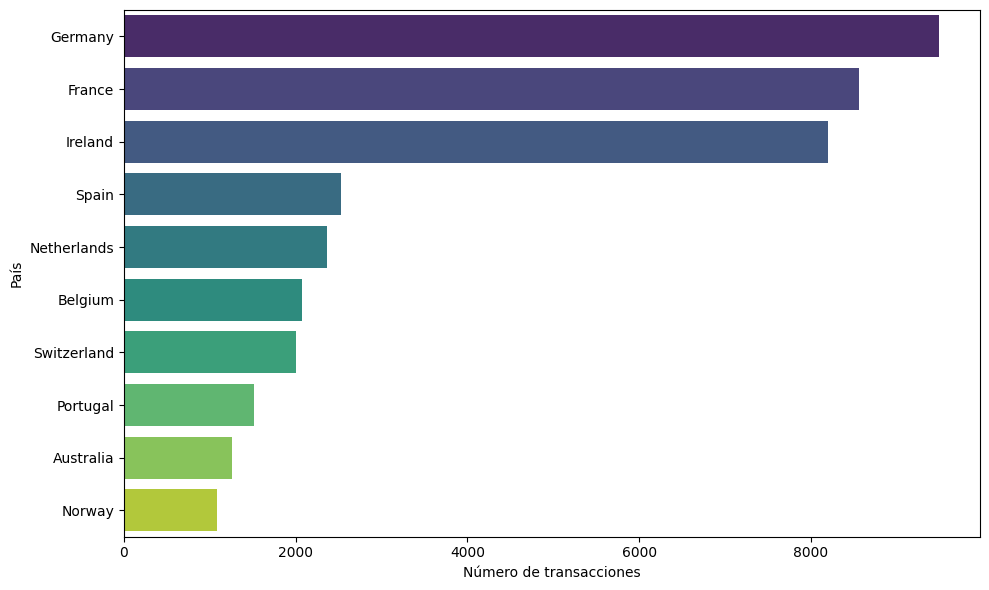

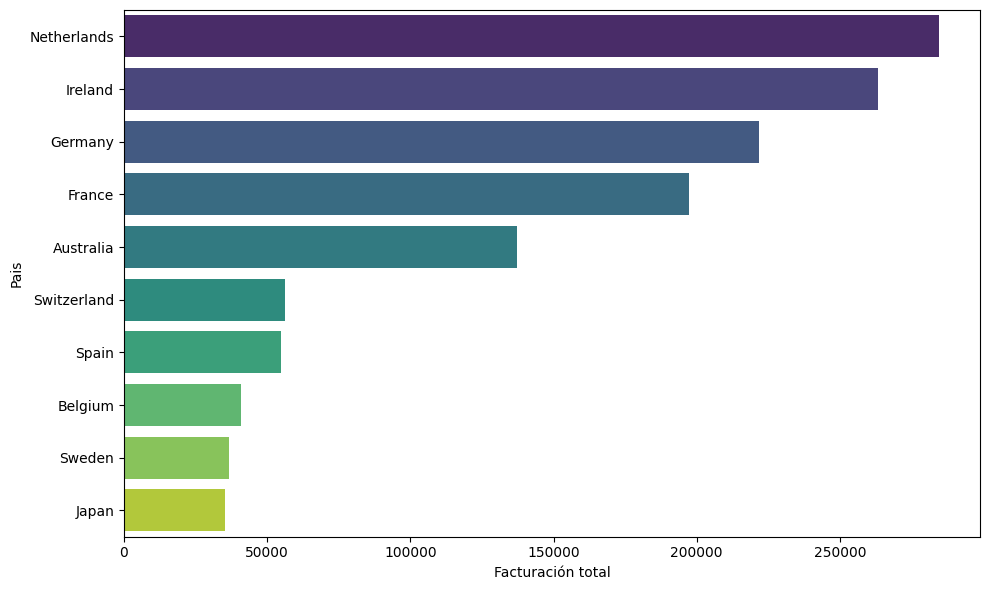

In [ ]:
# Top paises compradores (#)
top_paises = df['Country'].value_counts()
top_paises = top_paises[(top_paises > 1000) & (top_paises.index != 'United Kingdom')]
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_paises.values,
    y=top_paises.index,
    hue=top_paises.index,  
    palette='viridis',
    dodge=False,
    legend=False
)
plt.xlabel('Número de transacciones')
plt.ylabel('País')
plt.tight_layout()
plt.savefig("Imagenes/Top10paises_volumen.png", dpi=300, bbox_inches='tight')
plt.show()

# Top paises compradores ($)
revenue_por_pais = df.groupby('Country')['Revenue'].sum()
revenue_filtrado = revenue_por_pais[(revenue_por_pais > 1000) & (revenue_por_pais.index != 'United Kingdom')]
top_revenue_paises = revenue_filtrado.sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_revenue_paises.values,
    y=top_revenue_paises.index,
    hue=top_revenue_paises.index, 
    palette='viridis',
    dodge=False,
    legend=False
)
plt.xlabel('Facturación total')
plt.ylabel('Pais')
plt.tight_layout()
plt.savefig("Imagenes/Top10paises_revenue.png", dpi=300, bbox_inches='tight')
plt.show()

**Interpretación:** El Reino Unido es el mercado principal, sin embargo, identificar que países también presentan una actividad significativa tanto en numero de transacciones como en réditos puede ayudar a justificar estrategias de expansión o localización.

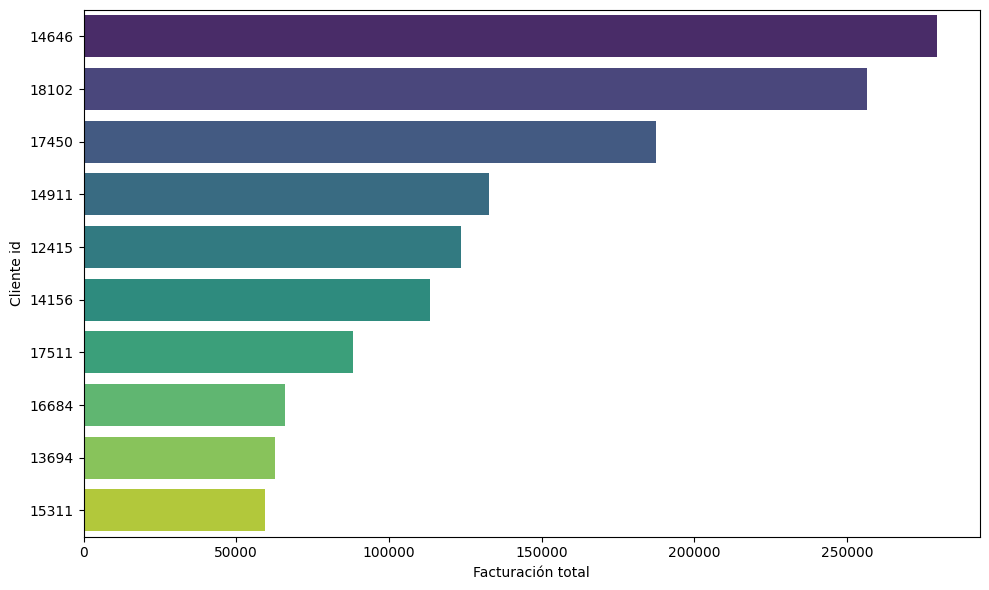

In [ ]:
# Top clientes compradores ($ )
df['CustomerID']=df['CustomerID'].astype(str)
revenue_por_pais = df.groupby('CustomerID')['Revenue'].sum()
revenue_filtrado = revenue_por_pais[(revenue_por_pais > 1000) & (revenue_por_pais.index != '99999')]
top_revenue_paises = revenue_filtrado.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_revenue_paises.values,
    y=top_revenue_paises.index,
    hue=top_revenue_paises.index, 
    palette='viridis',
    dodge=False,
    legend=False
)
plt.xlabel('Facturación total')
plt.ylabel('Cliente id')
plt.tight_layout()
plt.savefig("Imagenes/Top10clientes.png", dpi=300, bbox_inches='tight')
plt.show()
    

**interpretación**: Se busca identificar a estos clientes y para campañas de fidelización, personalización de ofertas, etc.